In [1]:
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import socket

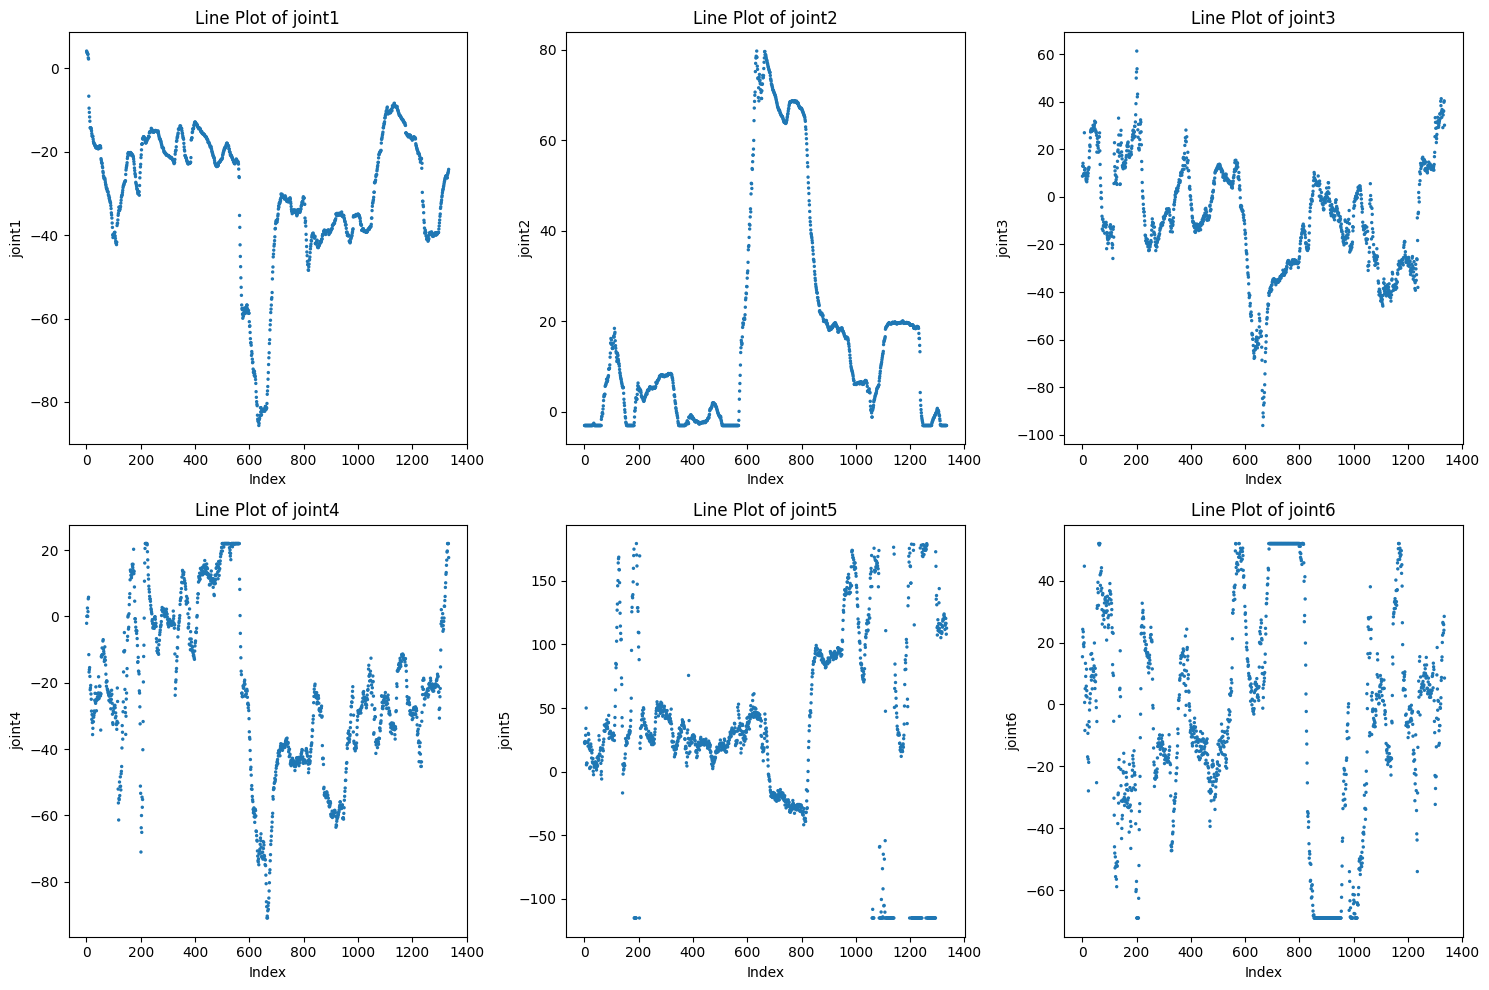

In [2]:
# Define the name of the CSV file
csv_filename = '/home/giakhang/tomo2_imaging/src/tomo_operator_control/tomo_operator_control/joint_angles_6_dof_2.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_filename)

# Check if the DataFrame has 6 columns
if df.shape[1] != 6:
    raise ValueError("The CSV file does not have 6 columns.")

# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Iterate over each column and create a scatter plot
for i, column in enumerate(df.columns):
    column_data = df[column].to_list()
    #axs[i].plot(list(range(1, len(column_data) + 1)), column_data, marker='o', markersize=1)  # Plot with markers
    axs[i].scatter(list(range(1, len(column_data) + 1)), 
        column_data, 
        sizes=[2] * len(column_data))
    axs[i].set_title(f'Line Plot of {column}')
    axs[i].set_xlabel('Index')
    axs[i].set_ylabel(column)

# Adjust layout to make room for the titles
plt.tight_layout()

# Save the figure to a file or show it
plt.show()  # Or display in a window

In [3]:
FPS = 20
delta_t_ms = 1000 / 20
system_noise_degree_per_second = 10
system_noise_degree_per_frame_ms = (1000 / FPS) * system_noise_degree_per_second / 1000

A = np.array([[0, delta_t_ms], [0, 1]])
#A = np.array([[1, 1], [0, 1]])
Q = np.array([[1e-2, 0], [0, 1e-2]])
#Q = np.array([[1, 0], [0, 1]])
G = np.array([[1, 0]])
#R = np.array([[system_noise_degree_per_frame_ms]])
R = np.array([[2]])

#joint_1_max_degree_velocity_per_second = 86.998
#joint_1_max_degree_velocity_per_frame_ms = joint_1_max_degree_velocity_per_second * (1000 / FPS) / 1000
#x_init = np.array([0, joint_1_max_degree_velocity_per_frame_ms])
#sigma_init = np.array([[0.01, 0], [0, 1]])

def kalman_filter(angles_measurements, x_init, sigma_init):
    optimal_estimate_angles = []

    x_hat, sigma = x_init, sigma_init
    for i in range(len(angles_measurements)):
        # Prediction
        x_hat = A @ x_hat
        sigma = A @ sigma @ A.T + Q

        # Measurement
        y = angles_measurements[i]
        kalman_gain = sigma @ G.T @ np.linalg.inv(G @ sigma @ G.T + R)
        x_hat = x_hat + kalman_gain @ (y - G @ x_hat)
        sigma = (np.eye(len(sigma)) - kalman_gain @ G) @ sigma
        
        optimal_estimate_angles.append(x_hat[0])

    return optimal_estimate_angles

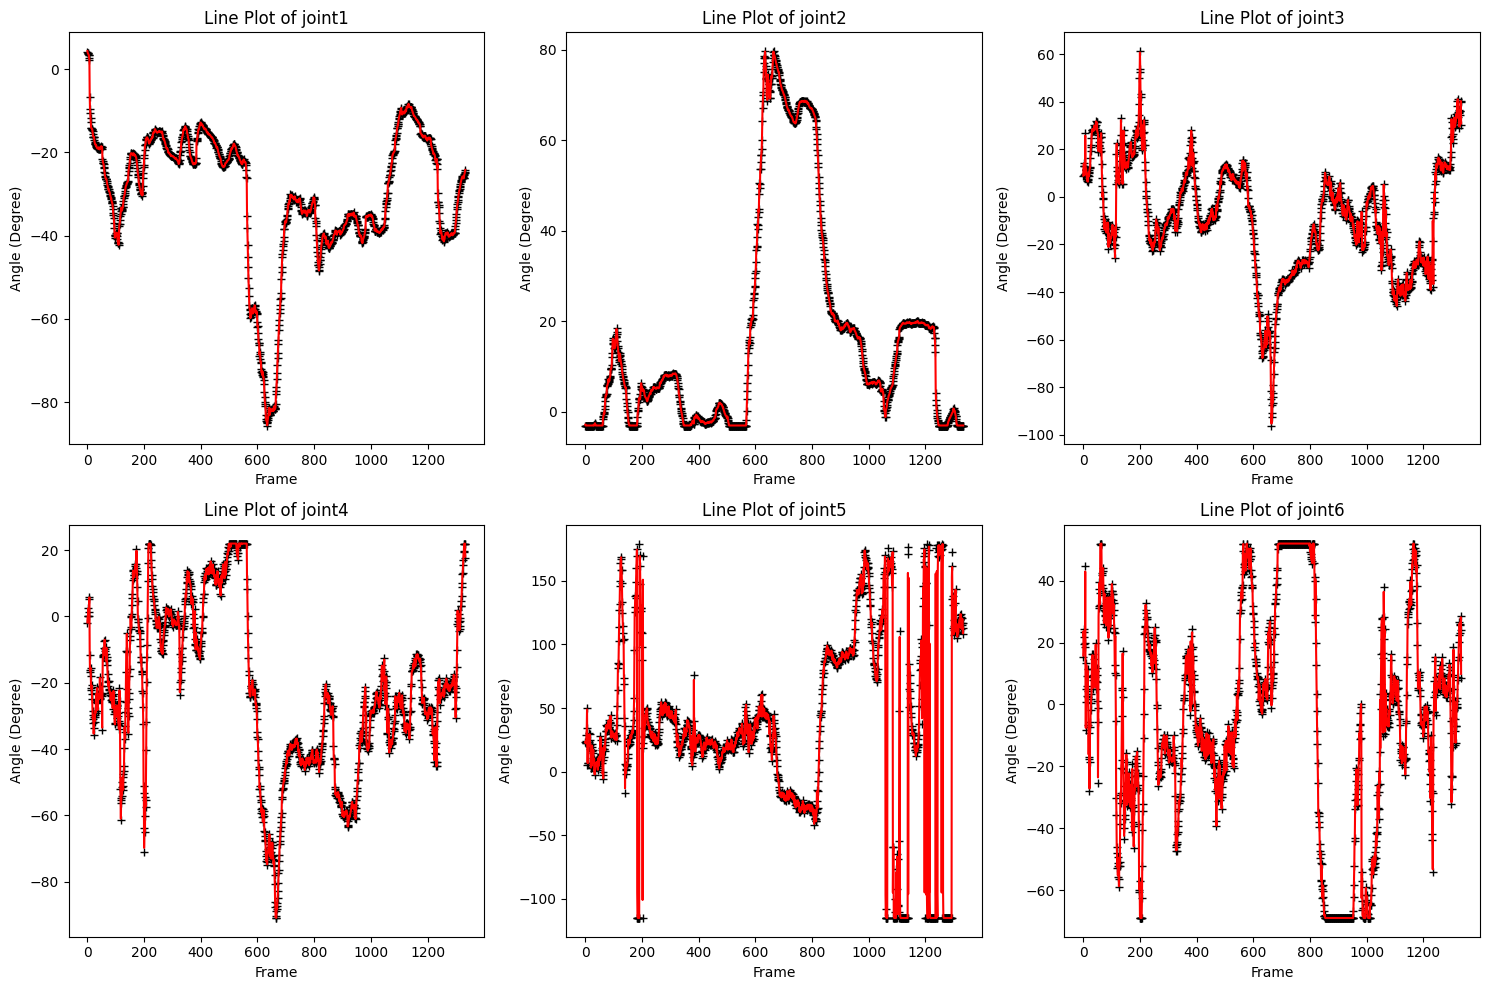

In [4]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the array of axes for easy iteration
axs = axs.flatten()

joints_max_velocities_rad_per_second = np.array([1.5184, 1.5184, 2.1074, 2.1074, 3.3719, 3.3719])
joints_max_velocities_deg_per_second = joints_max_velocities_rad_per_second * 180 / math.pi

# Iterate over each column and create a scatter plot
for i, column in enumerate(df.columns):
    column_data = df[column].to_numpy()

    joint_i_max_degree_velocity_per_second = joints_max_velocities_deg_per_second[i]
    joint_i_max_degree_velocity_per_frame_ms = joint_i_max_degree_velocity_per_second * (1000 / FPS) / 1000
    x_init = np.array([0, joint_i_max_degree_velocity_per_frame_ms])
    #x_init = np.array([0, 5])
    sigma_init = np.array([[0.01, 0], [0, 1]])
    optimal_estimate_angles = kalman_filter(column_data, x_init, sigma_init)
    
    axs[i].plot(column_data, "k+", label="Measurement")  # Plot with markers
    axs[i].plot(optimal_estimate_angles,'r-',label='Estimate Angle')
    axs[i].set_title(f'Line Plot of {column}')
    axs[i].set_xlabel('Frame')
    axs[i].set_ylabel("Angle (Degree)")

# Adjust layout to make room for the titles
plt.tight_layout()

# Save the figure to a file or show it
plt.show()  # Or display in a window

In [5]:
Q

array([[0.01, 0.  ],
       [0.  , 0.01]])